In [98]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [99]:
#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss)
gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'

gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/sapelo_yearly_climatology-2019.shp'

flux_ga = geemap.shp_to_ee(gce_fluxproper)

In [100]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 71,
 'QA_RADSAT': 71,
 'SR_ATMOS_OPACITY': 71,
 'SR_B1': 71,
 'SR_B2': 71,
 'SR_B3': 71,
 'SR_B4': 71,
 'SR_B5': 71,
 'SR_B7': 71,
 'SR_CLOUD_QA': 71,
 'ST_ATRAN': 71,
 'ST_B6': 71,
 'ST_CDIST': 71,
 'ST_DRAD': 71,
 'ST_EMIS': 71,
 'ST_EMSD': 71,
 'ST_QA': 71,
 'ST_TRAD': 71,
 'ST_URAD': 71}

In [101]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))


#NOTE: above is 7-9 calibration; below is 8-9 calibration

# def addFLATSL9(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(1.51 + 12.5*(0.945*(RED-SWIR)/(RED+SWIR) - 0.055) - 41.2*(0.974* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.0005)))', {
#             'SWIR': image.select('SR_B6'),
#             'NIR': image.select('SR_B5'),
#             'RED': image.select('SR_B4'),
#             'BLUE': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATS(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B6'),
#             'RED': image.select('SR_B4'),
#             'GREEN': image.select('SR_B3')
#         })
    
#     return image.addBands(flats.rename('flats'))

# def addFLATSL5(image):
#     flats = ee.Image(0).expression(
#         '1/(1+2.718281828459045**-(-1.57 + 20*(RED-SWIR)/(RED+SWIR) + 68.6*(GREEN-RED)/(GREEN+RED)))', {
#             'SWIR': image.select('SR_B5'),
#             'RED': image.select('SR_B3'),
#             'GREEN': image.select('SR_B2')
#         })
    
#     return image.addBands(flats.rename('flats'))

#NDWI
def addndwi(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

def addndwiL5(image):
    ndwi = ee.Image(0).expression(
        '((RED-SWIR)/(RED+SWIR))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndwi.rename('ndwi'))

#PHENO
def addpheno(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B6'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(pheno.rename('pheno'))

def addphenoL5(image):
    pheno = ee.Image(0).expression(
        '((GREEN-RED)/(RED+GREEN))', {
            'SWIR': image.select('SR_B5'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(pheno.rename('pheno'))

#NIRv
def addnirv(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(nirv.rename('nirv'))

def addnirvL5(image):
    nirv = ee.Image(0).expression(
        'NIR*(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(nirv.rename('nirv'))

#NDVI
def addndvi(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addndviL5(image):
    ndvi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+RED)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

#EVI
def addeviL5(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B3'),
            'NIR': image.select('SR_B4'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(evi.rename('evi'))

def addevi(image):
    evi = ee.Image(0).expression(
        '(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)', {
            'RED': image.select('SR_B4'),
            'NIR': image.select('SR_B5'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(evi.rename('evi'))

#12/01/22
#VARI
def addvariL5(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(vari.rename('vari'))

def addvari(image):
    vari = ee.Image(0).expression(
        '(GREEN-RED)/(GREEN+RED-BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(vari.rename('vari'))


#GLI
def addgliL5(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2'),
            'BLUE': image.select('SR_B1'),

        })
    
    return image.addBands(gli.rename('gli'))

def addgli(image):
    gli = ee.Image(0).expression(
        '((GREEN-RED) + (GREEN-BLUE))/(2*GREEN+RED+BLUE)', {
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3'),
            'BLUE': image.select('SR_B2'),

        })
    
    return image.addBands(gli.rename('gli'))

In [131]:
# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)

In [132]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [133]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(addndwi).map(addpheno).map(addevi).map(addvari).map(addndvi).map(add_date_band)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(addndwiL5).map(addphenoL5).map(addeviL5).map(addvariL5).map(addndviL5).map(add_date_band)
l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(addndwiL5).map(addphenoL5).map(addeviL5).map(addvariL5).map(addndviL5).map(add_date_band)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(addndwi).map(addpheno).map(addevi).map(addvari).map(addndvi).map(add_date_band)

In [341]:
#Flux point

point_flux = ee.Geometry.Point([-81.283458, 31.444218])

# point_flux = ee.Geometry.Point([-81.284983, 31.444205]) ##Another point just to test things out


In [342]:

def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = point_flux,
        scale = 30,
        tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
    )
    return feature

    
# df = geemap.ee_to_pandas(l5_col.map(rasterExtraction).flatten())

df5 = geemap.ee_to_pandas(l5_col.map(rasterExtraction).flatten())
df7 = geemap.ee_to_pandas(l7_col.map(rasterExtraction).flatten())
df8 = geemap.ee_to_pandas(l8_col.map(rasterExtraction).flatten())
df9 = geemap.ee_to_pandas(l9_col.map(rasterExtraction).flatten())

df = pd.concat([df5, df7, df8, df9])

df


,ST_EMSD,ST_URAD,SR_ATMOS_OPACITY,acquisition_date,flats,vari,ST_QA,ST_DRAD,evi,ndvi,...,SR_CLOUD_QA,SR_B7,QA_PIXEL,ST_CDIST,pheno,SR_B1,ndwi,SR_QA_AEROSOL,SR_B6,ST_B10
0,60,3414,320.0,463073081355,0.030486,0.069949,304,1511,0.050079,0.352189,...,1.0,0.039855,5440,304,0.046861,0.036802,-0.237243,NaN,NaN,NaN
1,60,3465,301.0,464455483922,0.024236,0.092255,657,1502,0.065005,0.372492,...,1.0,0.045465,5440,15,0.055431,0.051488,-0.206500,NaN,NaN,NaN
2,60,2631,221.0,472749888118,0.999347,0.302355,580,1193,-0.011038,-0.165378,...,32.0,0.015242,5504,27,0.122734,0.046455,0.445656,NaN,NaN,NaN
3,60,352,110.0,505927323349,0.999996,0.027074,402,199,-0.022467,-0.250692,...,32.0,0.003087,5504,51,0.016807,0.045300,0.824594,NaN,NaN,NaN
4,60,4810,1755.0,522515825302,0.387854,0.259116,447,2037,0.076525,0.375091,...,8.0,0.024262,5440,722,0.136282,0.069830,0.098800,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,60,1209,NaN,1673971268485,0.009050,-0.038578,279,609,0.038990,0.413654,...,NaN,0.042220,21824,186,-0.027192,0.012135,-0.385518,96.0,0.070270,289.063624
36,60,368,NaN,1676736071781,0.004074,-0.048169,211,211,0.046871,0.447736,...,NaN,0.047747,21824,443,-0.032307,0.014940,-0.415952,96.0,0.078823,288.544085
37,60,845,NaN,1682265638084,0.583094,-0.042558,324,446,0.020546,0.202842,...,NaN,0.038398,21824,103,-0.027091,0.026655,-0.108451,96.0,0.055090,298.042762
38,60,2763,NaN,1686412811581,0.216521,-0.014374,631,1276,0.037932,0.262708,...,NaN,0.053907,21824,3,-0.009000,0.036665,-0.165791,160.0,0.084020,305.473538


In [343]:
# for col in df.columns:
#     print(col)

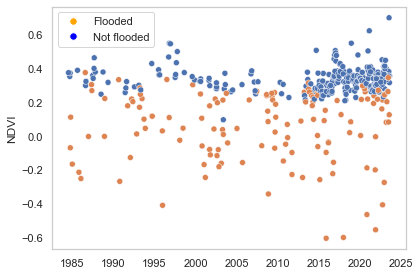

In [348]:

# Convert the acquisition_date column to datetime format
df['acquisition_date'] = pd.to_datetime(df['acquisition_date'], unit = 'ms')
df['Date'] = df['acquisition_date'].dt.strftime('%m/%d/%Y')

df = df[df['ndvi'] < 0.8]

df['acquisition_date'] = pd.to_datetime(df['acquisition_date'])

threshold = 0.2

sns.set_style("whitegrid", {'axes.grid' : False})

# Color code cats based on the threshold
df['color'] = ['red' if x>0.2 else 'blue' for x in df['flats']]


# Plot the time series
ax = sns.scatterplot(
    x="acquisition_date",
    y="ndvi",
    hue="color",
    legend=False,
    marker = 'o',
    data=df
)

# Create custom legend labels and handles
custom_labels = ['Flooded', 'Not flooded']
custom_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=7.5),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=7.5)]

# Add the custom legend
ax.legend(custom_handles, custom_labels, loc='best')
plt.xlabel("")
plt.ylabel("NDVI")

plt.tight_layout()

# plt.savefig('pointall2.png', bbox_inches='tight', dpi = 300)

In [345]:
import statistics
x = df[df['flats'] <= 0.2]
x

y = df[df['flats'] > 0.2]

statistics.mean(x['ndvi'])


0.3347894114233139

In [346]:
df

,ST_EMSD,ST_URAD,SR_ATMOS_OPACITY,acquisition_date,flats,vari,ST_QA,ST_DRAD,evi,ndvi,...,QA_PIXEL,ST_CDIST,pheno,SR_B1,ndwi,SR_QA_AEROSOL,SR_B6,ST_B10,Date,color
0,60,3414,320.0,1984-09-03 15:24:41.355,0.030486,0.069949,304,1511,0.050079,0.352189,...,5440,304,0.046861,0.036802,-0.237243,NaN,NaN,NaN,09/03/1984,blue
1,60,3465,301.0,1984-09-19 15:24:43.922,0.024236,0.092255,657,1502,0.065005,0.372492,...,5440,15,0.055431,0.051488,-0.206500,NaN,NaN,NaN,09/19/1984,blue
2,60,2631,221.0,1984-12-24 15:24:48.118,0.999347,0.302355,580,1193,-0.011038,-0.165378,...,5504,27,0.122734,0.046455,0.445656,NaN,NaN,NaN,12/24/1984,red
3,60,352,110.0,1986-01-12 15:22:03.349,0.999996,0.027074,402,199,-0.022467,-0.250692,...,5504,51,0.016807,0.045300,0.824594,NaN,NaN,NaN,01/12/1986,red
4,60,4810,1755.0,1986-07-23 15:17:05.302,0.387854,0.259116,447,2037,0.076525,0.375091,...,5440,722,0.136282,0.069830,0.098800,NaN,NaN,NaN,07/23/1986,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,60,1209,NaN,2023-01-17 16:01:08.485,0.009050,-0.038578,279,609,0.038990,0.413654,...,21824,186,-0.027192,0.012135,-0.385518,96.0,0.070270,289.063624,01/17/2023,blue
36,60,368,NaN,2023-02-18 16:01:11.781,0.004074,-0.048169,211,211,0.046871,0.447736,...,21824,443,-0.032307,0.014940,-0.415952,96.0,0.078823,288.544085,02/18/2023,blue
37,60,845,NaN,2023-04-23 16:00:38.084,0.583094,-0.042558,324,446,0.020546,0.202842,...,21824,103,-0.027091,0.026655,-0.108451,96.0,0.055090,298.042762,04/23/2023,red
38,60,2763,NaN,2023-06-10 16:00:11.581,0.216521,-0.014374,631,1276,0.037932,0.262708,...,21824,3,-0.009000,0.036665,-0.165791,160.0,0.084020,305.473538,06/10/2023,red


In [335]:
df2 = df.loc[:, ['ndvi', 'flats', 'color']]
df2


,ndvi,flats,color
0,0.214846,0.541033,red
1,0.229787,0.320616,red
2,0.227102,0.647107,red
3,-0.450604,0.999997,red
4,0.320283,0.034358,blue
...,...,...,...
34,0.290821,0.249282,red
35,0.345665,0.079728,blue
36,0.095365,0.970432,red
37,0.278064,0.256619,red
